In [1]:
"""Mainly Edited for private usage by:  Ioannis Agriomallos
                                        Ioanna Mitsioni
License: BSD 3 clause

============= CURRENT CODE USAGE =============
Current code trains MLP Classifiers, to classify force input samples as stable (0) or slip (1)
---- Input
-> Input samples originate from optoforce sensors and are 3D (fx,fy,fz) and come from 2 different datasets, 
   one training, containing several surfaces as well as slip-stable occurrences, 
   and one validation, containing 1 surface with slip-stable occurrences on a completely unseen task-setup.
---- Input transformation
-> Several pre-features can be taken from these inputs, but here |f| is kept.
-> Several time and frequency domain features are extracted from pre-feature windows. 
  (implemented in 'featext.py') These windows have size w and are shifted by s on each sample
-> Then a feature selection-ranking is performed using MutualVariableInformation
-> Finally PCA is performed to keep a reduced set among the best selected features
---- Training of ML Classifiers
-> Several MLP Classifiers are trained for all combinations of selected featuresets-datasets
---- Results
-> Stats of classification results are kept inside each .npz along with the respective trained model
"""
print(__doc__)
import time
start_time = time.time()
import numpy as np
from copy import deepcopy
from ml_training import *
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib qt
# inline (suitable for ipython only, shown inside browser!) or qt (suitable in general, shown in external window!)
from matplotlib.colors import ListedColormap
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D

Mainly Edited for private usage by:  Ioannis Agriomallos
                                        Ioanna Mitsioni
License: BSD 3 clause

============= CURRENT CODE USAGE =============
Current code trains MLP Classifiers, to classify force input samples as stable (0) or slip (1)
---- Input
-> Input samples originate from optoforce sensors and are 3D (fx,fy,fz) and come from 2 different datasets, 
   one training, containing several surfaces as well as slip-stable occurrences, 
   and one validation, containing 1 surface with slip-stable occurrences on a completely unseen task-setup.
---- Input transformation
-> Several pre-features can be taken from these inputs, but here |f| is kept.
-> Several time and frequency domain features are extracted from pre-feature windows. 
  (implemented in 'featext.py') These windows have size w and are shifted by s on each sample
-> Then a feature selection-ranking is performed using MutualVariableInformation
-> Finally PCA is performed to keep a reduced 

In [2]:
class struct:
    def __init__(self):
        ####### TRAINING DEFAULTS
        self.cv = KFold(n_splits=5,random_state=42)
        self.scaler = StandardScaler()
        self.decomp = PCA(n_components=20)
        self.names = ["NearNb", "RBFSVM1", "MLP1", "RandFor"]
        self.classifiers = [KNeighborsClassifier(5),
                       SVC(gamma='auto', C=1),
                       MLPClassifier(solver='lbfgs',alpha=1e-4,hidden_layer_sizes=(10,10),random_state=1,verbose=True),
                       RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)]

        self.download = 0            # Download pre-computed (1) data or compute them all anew (0)
        self.delete_big_features = 1 # Delete (1) or keep (0) computed big-in-size features,
                                  # helping mainly to avoid several computations when recomputing features

        ############ INITIALISATION PARAMETERS ############
        self.window, self.shift = 1024, 20
        self.samplesperdataset = 10000
        self.havelabel = 1
        self.returntime = 0
        self.featlabel = 0         # 0: all features, 1: temporal, 2: frequency, 3: FFT only
        self.magnFFT = 0           # 0: FFT in magnitude format, 1: FFT in real and imag format,
        self.featall = 0           # 0: all, 1: feat1 (phinyomark's), 2: feat2 (golz's)
        self.CV = 5                # cross validation checks
        self.numfeat = 10          # number of features to show
        self.nfeat = 1000          # number of features to keep
        ###### Initialize necessary names and paths
        self.datapath = 'data/'
        self.datafile = self.datapath+'dataset.npz'
        self.validfile = self.datapath+'validation.mat'
        self.featpath = self.datapath+'features/'+str(self.window)+'_'+str(self.shift)+'/'
        self.allfeatpath = self.featpath+'AllFeatures/'
        self.prefeatname = 'prefeatures_scaled'+'_'+str(self.window)+'_'+str(self.shift)+'_'+str(self.samplesperdataset)
        self.prefeatfile = self.featpath+self.prefeatname+'.npz'
        self.featname = 'features_scaled'+'_'+str(self.window)+'_'+str(self.shift)+'_'+str(self.samplesperdataset)
        self.featfile = self.featpath+self.featname+'.npz'
        self.validfeatname = 'valid'+self.featname
        self.validfeatfile = self.featpath+self.validfeatname+'.npz'
        self.surffile = self.featpath+self.featname+'_2fing_6surf.npz'
        self.XYfile = self.featpath+self.featname+'_XY.npz'
        self.XYsplitfile = self.featpath+self.featname+'_XYsplit.npz'
        self.validsurffile = self.featpath+self.validfeatname+'_2fing_6surf.npz'
        self.validXYfile = self.featpath+self.validfeatname+'_XY.npz'
        self.validXYsplitfile = self.featpath+self.validfeatname+'_XYsplit.npz'
        self.respath = self.datapath+'scaled_results'
        self.toolfile = self.datapath+'bargraph.zip'
        self.toolpath = self.datapath+'bargraph-rel_4_8/'
        self.tool = './'+self.toolpath+'bargraph.pl'
######### INITIALIZE OBJECT-STRUCT WITH PARAMETERS AND PASS THEM TO ML MODULE ########
c = struct()
m = ml(c)

In [3]:
######### DOWNLOAD NECESSARY FILES ###########
download_required_files()

Necessary  data/dataset.npz  already here!
Necessary  data/validation.mat  already here!
Downloaded 575.7 MB of content in total!


In [4]:
############ TRAINING PROCEDURE ##############
# necessary steps before training
scales = [0.1, 0.5, 1.0, 2.0, 5.0, 20.0]
f,l,fd,m,m1,m2 = data_prep(c.datafile,scale=scales)                      # read input force and labels
prefeat = compute_prefeat(f)                                    # compute corresponding prefeatures
features, labels = feature_extraction(prefeat, m, c.featfile,
                                      c.featname+'_')            # feature extraction from prefeatures
# avg_feat_comp_time(prefeat)                                      # average feature extraction time
new_labels = label_cleaning(prefeat,labels,m)                   # trim labels, around change points
X,Y,Yn,Xsp,Ysp = computeXY(features,labels,new_labels,m1,m2,
                           c.XYfile,c.XYsplitfile)               # compute data and labels, trimmed and untrimmed
surf, surfla = computeXY_persurf(Xsp,Ysp,c.surffile)             # compute per surface data and labels
# training and offline testing
train_1_surface(surf,surfla)                                     # training of all combinations per 1 surface
train_2_surface(surf,surfla)                                     # training of all combinations per 2 surfaces
train_3_surface(surf,surfla)                                     # training of all combinations per 3 surfaces
train_4_surface(surf,surfla)                                     # training of all combinations per 4 surfaces
train_5_surface(surf,surfla)                                     # training of all combinations per 5 surfaces

---------------------------- LOADING DATA and COMPUTING NECESSARY STRUCTS ----------------------------
1 -> f1: (36,) (36,) (36, 4)
2 -> f2: (36,) (36,) (36, 4)
3 -> f: (72,) (72,) (72, 4)
4 -> m1,m2: 36 36 1.0 1.0
5 -> f=f+l: (72,) : [(345002, 4), (105001, 4), (210001, 4), (225002, 4), (130001, 4), (65001, 4), (195001, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (225002, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (75001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (65001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (65001, 4), (130001, 4), (195001, 4), (130001, 4), (195001, 4), (65001, 4), (345002, 4), (105001, 4), (210001, 4), (225002, 4), (130001, 4), (65001, 4), (195001, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (225002, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (75001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (6

---------------------------- Generating perf files for 1 surface -------------------------------------
---------------------------- Generating perf files for 2 surfaces ------------------------------------
---------------------------- Generating perf files for 3 surfaces ------------------------------------
---------------------------- Generating perf files for 4 surfaces ------------------------------------
---------------------------- Generating perf files for 5 surfaces ------------------------------------
---------------------------- Generating bar graphs for 1 surfaces ------------------------------------
---------------------------- Generating bar graphs for 2 surfaces ------------------------------------
---------------------------- Generating bar graphs for 3 surfaces ------------------------------------
---------------------------- Generating bar graphs for 4 surfaces ------------------------------------
---------------------------- Generating bar graphs for 5 surfaces -------

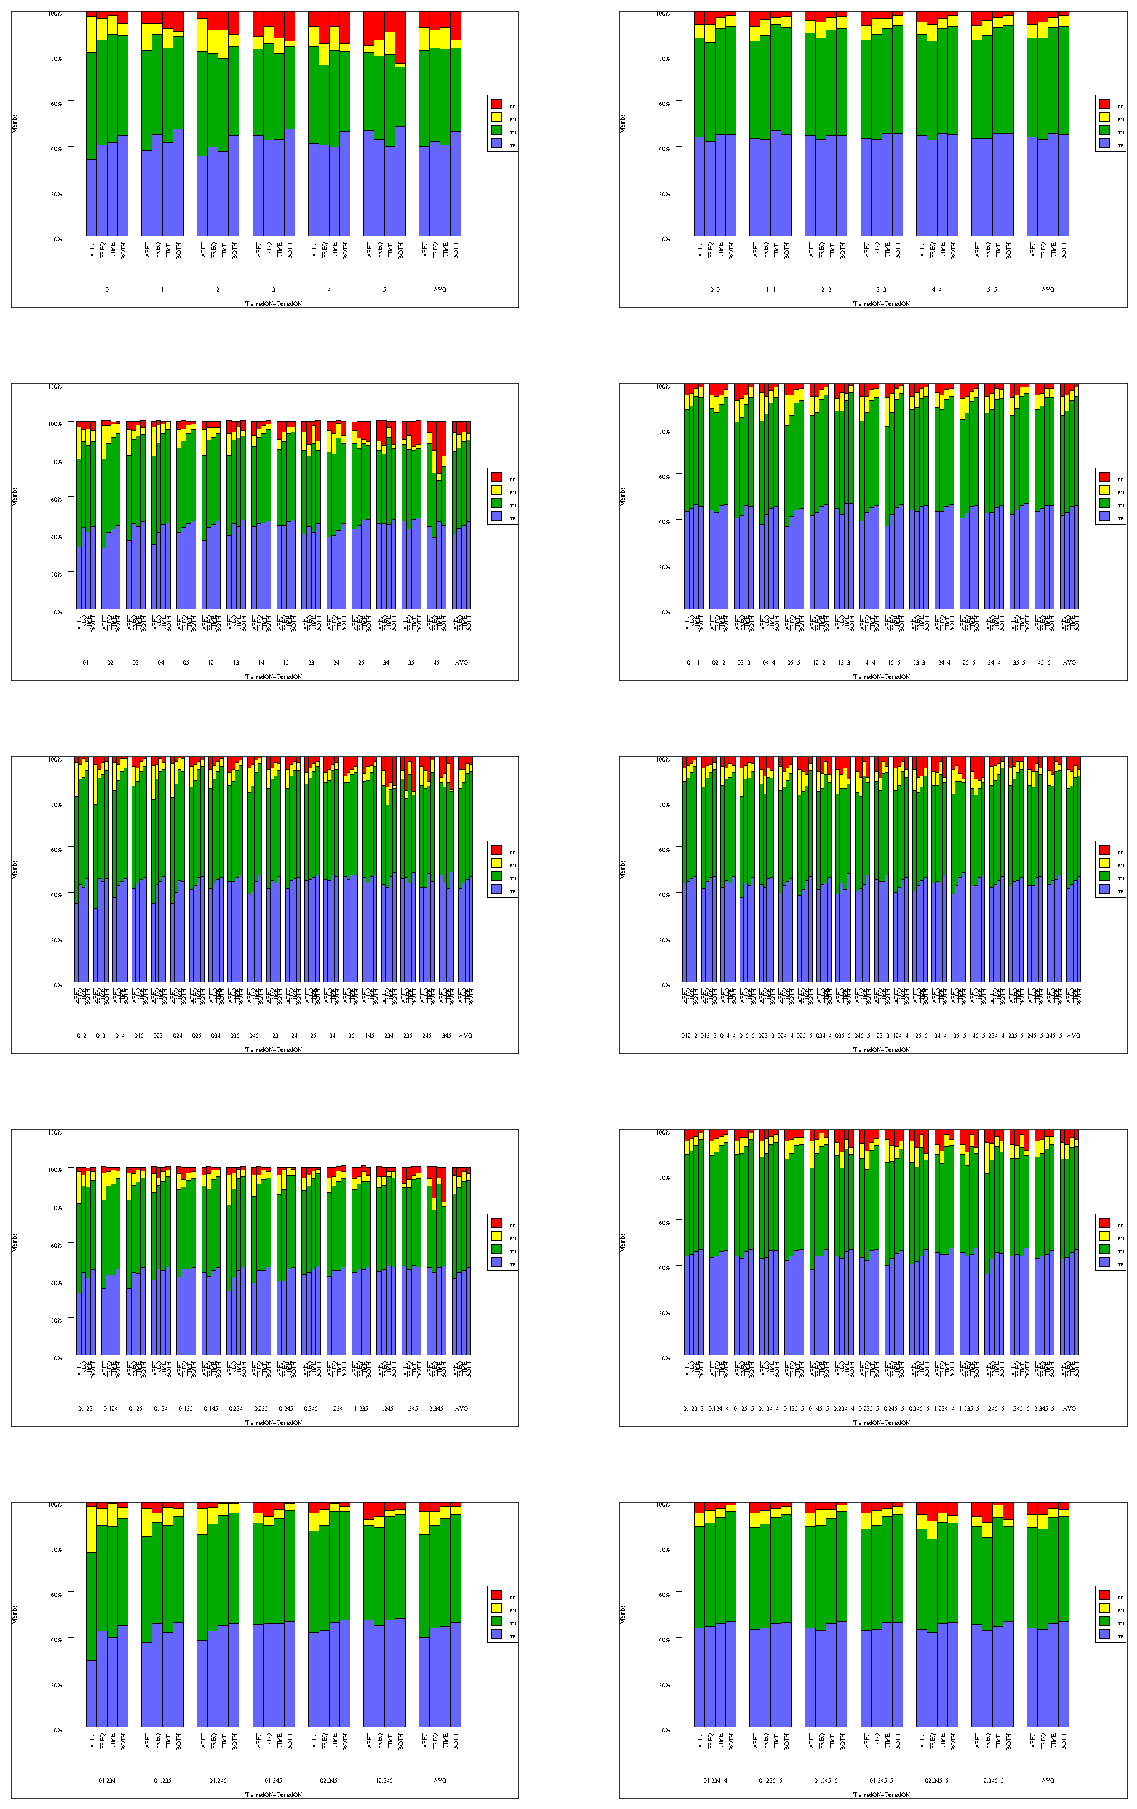

In [5]:
############ RESULT REPORTING ##############
# generate files with stats
bargraph_perf_gen1(6)
bargraph_perf_gen2(6)
bargraph_perf_gen3(6)
bargraph_perf_gen4(6)
bargraph_perf_gen5(6)
# use the bargraph tool to plot graphs from generated files
# -left column cross-accuracy (trained on one, tested on all the others), 
# -right column self-accuracy (trained and tested on the same)
# -each row i represents training only with i surfaces.
# -each stack represents a training group, each bar represents a subfeatureset(AFFT,FREQ,TIME,BOTH)
# -blue,green,yellow,red : TP,TN,FN,FP
plt.figure(figsize=(20,40))
for i in range(5):
    make_bargraphs_from_perf(i)

In [6]:
############ ONLINE TESTING PROCEDURE ##############
# same necessary steps as in training for data preparation
f,l,fd,member,m1,m2 = data_prep(c.validfile)
prefeat = compute_prefeat(f)
features, labels = feature_extraction(prefeat, member, c.validfeatfile, 'validfeat_')
new_labels = label_cleaning(prefeat,labels,member)
X,Y,Yn,Xsp,Ysp = computeXY(features,labels,new_labels,m1,m2,c.validXYfile,c.validXYsplitfile)
surf, surfla = computeXY_persurf(Xsp,Ysp,c.validsurffile)

---------------------------- LOADING DATA and COMPUTING NECESSARY STRUCTS ----------------------------
1 -> f1: (1, 1) (1, 1) (1, 1)
2 -> f2: (1, 1) (1, 1) (1, 1)
3 -> f: (2, 1) (2, 1) (2, 1)
4 -> m1,m2: 1 1 1.0 1.0
5 -> f=f+l: (2, 65000, 4) : [(65000, 4), (65000, 4)]
--------------------------------------- COMPUTING PREFEATURES ----------------------------------------
(2,) : [(65000, 2), (65000, 2)]
---------------------------------------- FEATURE EXTRACTION ------------------------------------------
sample: 0 , time(sec): 1.20 data/features/1024_20/AllFeatures/validfeat_0_red10000.pkl.z already here! (3199, 3107, 2)
sample: 1 , time(sec): 2.33 data/features/1024_20/AllFeatures/validfeat_1_red10000.pkl.z already here! (3199, 3107, 2)
Features NOT FOUND PRECOMPUTED! Feature Computation DONE in: 2.4560790062 sec 
features:  (2,) [(3199, 3107, 1), (3199, 3107, 1)]
labels:  (2,) [(3199,), (3199,)]
features:  (2,) , labels:  (2,)
----------- KEEPING LABEL's PURE (STABLE, SLIP) PHASE PARTS 

(3199,) (2769,) (2769,)
(2650,) (2650,)


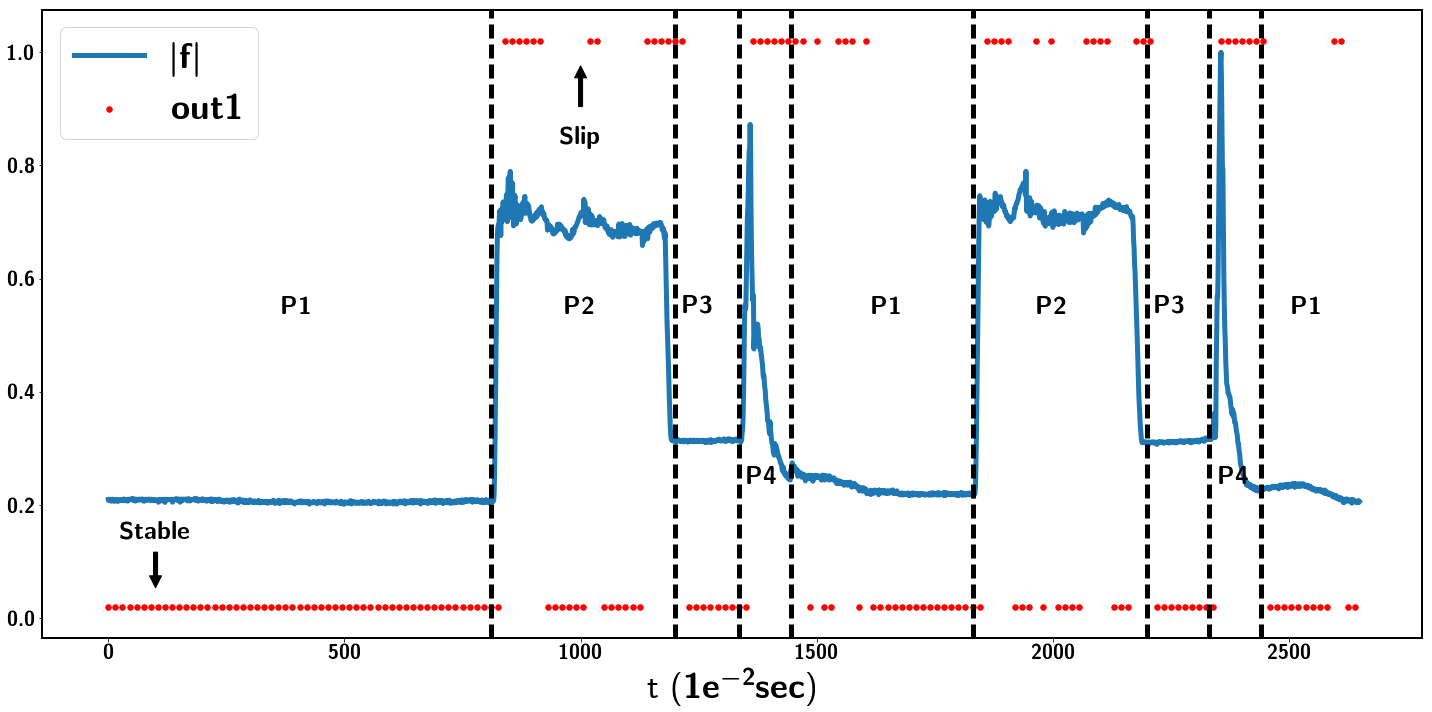

In [7]:
############ VISUALIZING ONLINE TESTING PROCEDURE ##############
window=c.window
subfeats = ['AFFT','FREQ','TIME','BOTH']
feats = ['fnorm','ftfn','fnormftfn']
matplotlib.rcParams['text.usetex'] = True

fileid = filename1(0,3,0,5)
fileidb = filename1(0,0,0,5)
fileid5 = filename5(0,3,0,1,2,3,4,5)
fileid5b = filename5(0,0,0,1,2,3,4,5)
model = np.load(fileid)['model'][0]
modelb = np.load(fileidb)['model'][0]
model5 = np.load(fileid5)['model'][0]
model5b = np.load(fileid5b)['model'][0]
Yout = model.predict(X[0])
Youtb = modelb.predict(Xsp[0][:,-window-2:-window/2-1])
Yout5 = model5.predict(Xsp[0])
Yout5b = model5b.predict(Xsp[0][:,-window-2:-window/2-1])
print Yout.shape, Yout5.shape, Yout5b.shape
plt.rc('text', usetex=True)
plt.rc('axes', linewidth=2)
plt.rc('font', weight='bold')
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
offset = 2000-window
endset = 2650
skipf = 20
skipy = 15
ax = plt.figure(figsize=(20,10))
tf = np.linalg.norm(f[0][offset+window::skipf,:3][:endset],axis=1)
p1, = plt.plot(tf/max(tf),linewidth=5)
ty = Yout[offset/skipf:][:endset]+0.02
print tf.shape, ty.shape
p = plt.scatter(range(len(tf))[::skipy],ty[::skipy],color='red',s=30)
plt.hold
plt.text(100, 0.15, r'\textbf{Stable}', ha="center", va="center", rotation=0,
            size=25)
plt.text(1000, 0.85, r'\textbf{Slip}', ha="center", va="center", rotation=0,
            size=25)
plt.annotate('', fontsize=10, xy=(100, 0.05), xytext=(100, 0.12),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('', xy=(1000, 0.98), xytext=(1000, 0.9),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.text(400, 0.55, r'\textbf{P1}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=810,linestyle='dashed',color='black',linewidth=5)
plt.text(1000, 0.55, r'\textbf{P2}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1200,linestyle='dashed',color='black',linewidth=5)
plt.text(1250, 0.55, r'\textbf{P3}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1335,linestyle='dashed',color='black',linewidth=5)
plt.text(1385, 0.25, r'\textbf{P4}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1445,linestyle='dashed',color='black',linewidth=5)
plt.text(1650, 0.55, r'\textbf{P1}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1830,linestyle='dashed',color='black',linewidth=5)
plt.text(2000, 0.55, r'\textbf{P2}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=2200,linestyle='dashed',color='black',linewidth=5)
plt.text(2250, 0.55, r'\textbf{P3}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=2330,linestyle='dashed',color='black',linewidth=5)
plt.text(2385, 0.25, r'\textbf{P4}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=2440,linestyle='dashed',color='black',linewidth=5)
plt.text(2540, 0.55, r'\textbf{P1}', ha="center", va="center", rotation=0,
            size=25)
plt.xlabel(r't ($1e^{-2} sec$)',fontsize=35)
# plt.yticks([])
plt.legend([p1,p],[r'$|\textbf{f}|$',r'\textbf{out1}'],loc=2, prop={'size': 35})
plt.tick_params(labelsize=20)
plt.tight_layout()
savefig(c.datapath+'validation.pdf', bbox_inches='tight')


In [8]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.0N_kp3.5_152Hz_validation.mat')
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.0N_kp3.5_152Hz_validation_rot.mat')

Filename for prediction: ati_new_fd1.0N_kp3.5_152Hz_validation.mat
1.34205
1.34205
Accuracy for surface  0 0.901201602136 0.989319092123
TN(stable) and TP(slip) for surface  0 0.931232091691 0.875 | 0.982808022923 0.995
Accuracy for surface  1 0.935914552737 0.990654205607
TN(stable) and TP(slip) for surface  1 0.97994269341 0.8975 | 1.0 0.9825
Accuracy for surface  2 0.955941255007 0.94526034713
TN(stable) and TP(slip) for surface  2 1.0 0.9175 | 1.0 0.8975
Accuracy for surface  3 0.899866488652 0.993324432577
TN(stable) and TP(slip) for surface  3 0.994269340974 0.8175 | 1.0 0.9875
Accuracy for surface  4 0.883845126836 0.910547396529
TN(stable) and TP(slip) for surface  4 0.948424068768 0.8275 | 0.965616045845 0.8625
Accuracy for surface  5 0.961281708945 0.818424566088
TN(stable) and TP(slip) for surface  5 1.0 0.9275 | 1.0 0.66
Accuracy for dataset    0.923008455719 0.941255006676
TN(stable) and TP(slip) for dataset  0.97564469914 0.877083333333 | 0.991404011461 0.8975
Filename fo

In [9]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.5N_kp3_152Hz_validation.mat')
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.5N_kp3_152Hz_validation_rot.mat')

Filename for prediction: ati_new_fd1.5N_kp3_152Hz_validation.mat
2.02426
2.02426
Accuracy for surface  0 0.858477970628 0.990654205607
TN(stable) and TP(slip) for surface  0 0.822349570201 0.89 | 0.985673352436 0.995
Accuracy for surface  1 0.890520694259 0.991989319092
TN(stable) and TP(slip) for surface  1 0.962750716332 0.8275 | 1.0 0.985
Accuracy for surface  2 0.894526034713 0.990654205607
TN(stable) and TP(slip) for surface  2 0.888252148997 0.9 | 1.0 0.9825
Accuracy for surface  3 0.870493991989 0.953271028037
TN(stable) and TP(slip) for surface  3 0.919770773639 0.8275 | 1.0 0.9125
Accuracy for surface  4 0.961281708945 0.939919893191
TN(stable) and TP(slip) for surface  4 0.971346704871 0.9525 | 0.968481375358 0.915
Accuracy for surface  5 0.938584779706 0.805073431242
TN(stable) and TP(slip) for surface  5 1.0 0.885 | 1.0 0.635
Accuracy for dataset    0.902314196707 0.94526034713
TN(stable) and TP(slip) for dataset  0.92741165234 0.880416666667 | 0.992359121299 0.904166666667

In [10]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.0N_kp3.5_326Hz_validation.mat')
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.0N_kp3.5_326Hz_validation_rot.mat')

Filename for prediction: ati_new_fd1.0N_kp3.5_326Hz_validation.mat
1.51563
1.51563
Accuracy for surface  0 0.933244325768 0.914552736983
TN(stable) and TP(slip) for surface  0 0.928366762178 0.9375 | 1.0 0.84
Accuracy for surface  1 0.955941255007 0.889185580774
TN(stable) and TP(slip) for surface  1 0.991404011461 0.925 | 1.0 0.7925
Accuracy for surface  2 0.970627503338 0.6782376502
TN(stable) and TP(slip) for surface  2 0.985673352436 0.9575 | 1.0 0.3975
Accuracy for surface  3 0.90520694259 0.829105473965
TN(stable) and TP(slip) for surface  3 1.0 0.8225 | 1.0 0.68
Accuracy for surface  4 0.973297730307 0.683578104139
TN(stable) and TP(slip) for surface  4 0.985673352436 0.9625 | 1.0 0.4075
Accuracy for surface  5 0.974632843792 0.618157543391
TN(stable) and TP(slip) for surface  5 1.0 0.9525 | 1.0 0.285
Accuracy for dataset    0.952158433467 0.768802848242
TN(stable) and TP(slip) for dataset  0.981852913085 0.92625 | 1.0 0.567083333333
Filename for prediction: ati_new_fd1.0N_kp3.5

In [11]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.5N_kp3_326Hz_validation.mat')
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.5N_kp3_326Hz_validation_rot.mat')

Filename for prediction: ati_new_fd1.5N_kp3_326Hz_validation.mat
1.8981
1.8981
Accuracy for surface  0 0.883845126836 0.955941255007
TN(stable) and TP(slip) for surface  0 0.916905444126 0.855 | 0.988538681948 0.9275
Accuracy for surface  1 0.805073431242 0.97997329773
TN(stable) and TP(slip) for surface  1 0.699140401146 0.8975 | 1.0 0.9625
Accuracy for surface  2 0.877169559413 0.985313751669
TN(stable) and TP(slip) for surface  2 0.845272206304 0.905 | 1.0 0.9725
Accuracy for surface  3 0.94526034713 0.914552736983
TN(stable) and TP(slip) for surface  3 1.0 0.8975 | 1.0 0.84
Accuracy for surface  4 0.943925233645 0.915887850467
TN(stable) and TP(slip) for surface  4 0.945558739255 0.9425 | 0.988538681948 0.8525
Accuracy for surface  5 0.957276368491 0.798397863818
TN(stable) and TP(slip) for surface  5 1.0 0.92 | 1.0 0.6225
Accuracy for dataset    0.902091677793 0.925011125946
TN(stable) and TP(slip) for dataset  0.901146131805 0.902916666667 | 0.996179560649 0.862916666667
Filename

In [12]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.0N_kp3.5_836Hz_validation.mat')
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.0N_kp3.5_836Hz_validation_rot.mat')

Filename for prediction: ati_new_fd1.0N_kp3.5_836Hz_validation.mat
1.42474
1.42474
Accuracy for surface  0 0.750333778371 0.807743658211
TN(stable) and TP(slip) for surface  0 0.561604584527 0.915 | 1.0 0.64
Accuracy for surface  1 0.931909212283 0.771695594126
TN(stable) and TP(slip) for surface  1 0.962750716332 0.905 | 1.0 0.5725
Accuracy for surface  2 0.975967957276 0.64085447263
TN(stable) and TP(slip) for surface  2 1.0 0.955 | 1.0 0.3275
Accuracy for surface  3 0.951935914553 0.672897196262
TN(stable) and TP(slip) for surface  3 0.991404011461 0.9175 | 1.0 0.3875
Accuracy for surface  4 0.978638184246 0.592790387183
TN(stable) and TP(slip) for surface  4 0.991404011461 0.9675 | 1.0 0.2375
Accuracy for surface  5 0.954606141522 0.530040053405
TN(stable) and TP(slip) for surface  5 0.97994269341 0.9325 | 1.0 0.12
Accuracy for dataset    0.923898531375 0.669336893636
TN(stable) and TP(slip) for dataset  0.914517669532 0.932083333333 | 1.0 0.380833333333
Filename for prediction: at

In [13]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.5N_kp3.5_836Hz_validation.mat')
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.5N_kp3.5_836Hz_validation_rot.mat')

Filename for prediction: ati_new_fd1.5N_kp3.5_836Hz_validation.mat
7.66321
7.66321
Accuracy for surface  0 0.964781216649 0.949839914621
TN(stable) and TP(slip) for surface  0 0.916905444126 0.993197278912 | 0.968481375358 0.938775510204
Accuracy for surface  1 0.973319103522 0.881536819637
TN(stable) and TP(slip) for surface  1 0.962750716332 0.979591836735 | 1.0 0.811224489796
Accuracy for surface  2 0.916755602988 0.685165421558
TN(stable) and TP(slip) for surface  2 1.0 0.867346938776 | 1.0 0.498299319728
Accuracy for surface  3 0.932764140875 0.656350053362
TN(stable) and TP(slip) for surface  3 0.994269340974 0.896258503401 | 1.0 0.452380952381
Accuracy for surface  4 0.962646744931 0.586979722519
TN(stable) and TP(slip) for surface  4 0.991404011461 0.945578231293 | 1.0 0.341836734694
Accuracy for surface  5 0.897545357524 0.419423692636
TN(stable) and TP(slip) for surface  5 0.816618911175 0.945578231293 | 1.0 0.0748299319728
Accuracy for dataset    0.941302027748 0.69654927072

In [14]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1N_kp3_nofilt_validation.mat')
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1N_kp3_nofilt_validation_rot.mat')

Filename for prediction: ati_new_fd1N_kp3_nofilt_validation.mat
1.44638
1.44638
Accuracy for surface  0 0.580774365821 0.918558077437
TN(stable) and TP(slip) for surface  0 0.243553008596 0.875 | 1.0 0.8475
Accuracy for surface  1 0.50867823765 0.923898531375
TN(stable) and TP(slip) for surface  1 0.0630372492837 0.8975 | 1.0 0.8575
Accuracy for surface  2 0.663551401869 0.716955941255
TN(stable) and TP(slip) for surface  2 0.355300859599 0.9325 | 1.0 0.47
Accuracy for surface  3 0.516688918558 0.819759679573
TN(stable) and TP(slip) for surface  3 0.0974212034384 0.8825 | 1.0 0.6625
Accuracy for surface  4 0.696929238985 0.71829105474
TN(stable) and TP(slip) for surface  4 0.401146131805 0.955 | 1.0 0.4725
Accuracy for surface  5 0.58344459279 0.492656875834
TN(stable) and TP(slip) for surface  5 0.120343839542 0.9875 | 1.0 0.05
Accuracy for dataset    0.591677792612 0.765020026702
TN(stable) and TP(slip) for dataset  0.213467048711 0.921666666667 | 1.0 0.56
Filename for prediction: at

In [15]:
####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
prediction('ati_new_fd1.5N_kp3_nofilt_validation.mat')
####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
prediction('ati_new_fd1.5N_kp3_nofilt_validation_rot.mat')

Filename for prediction: ati_new_fd1.5N_kp3_nofilt_validation.mat
1.84994
1.84994
Accuracy for surface  0 0.765020026702 0.906542056075
TN(stable) and TP(slip) for surface  0 0.65329512894 0.8625 | 1.0 0.825
Accuracy for surface  1 0.750333778371 0.934579439252
TN(stable) and TP(slip) for surface  1 0.595988538682 0.885 | 1.0 0.8775
Accuracy for surface  2 0.953271028037 0.775700934579
TN(stable) and TP(slip) for surface  2 0.954154727794 0.9525 | 1.0 0.58
Accuracy for surface  3 0.742323097463 0.853137516689
TN(stable) and TP(slip) for surface  3 0.52435530086 0.9325 | 1.0 0.725
Accuracy for surface  4 0.92523364486 0.83044058745
TN(stable) and TP(slip) for surface  4 0.919770773639 0.93 | 1.0 0.6825
Accuracy for surface  5 0.921228304406 0.535380507343
TN(stable) and TP(slip) for surface  5 0.848137535817 0.985 | 1.0 0.13
Accuracy for dataset    0.84290164664 0.805963506898
TN(stable) and TP(slip) for dataset  0.749283667622 0.924583333333 | 1.0 0.636666666667
Filename for prediction

## Scaled Version of one of the above on the following ranges (0.1, 0.5, 1.0, 2.0, 5.0, 20.0)

In [18]:
for sc in [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 20.0, 50.0]:
    print "-------- SCALING = ",sc,"--------"
    ####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
    prediction('ati_new_fd1.5N_kp3_152Hz_validation.mat',scale=sc)
    ####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
    prediction('ati_new_fd1.5N_kp3_152Hz_validation_rot.mat',scale=sc)

-------- SCALING =  0.01 --------
Filename for prediction: ati_new_fd1.5N_kp3_152Hz_validation.mat
2.02426
0.0202426
Accuracy for surface  0 0.256341789052 0.883845126836
TN(stable) and TP(slip) for surface  0 0.0515759312321 0.435 | 1.0 0.7825
Accuracy for surface  1 0.30173564753 0.889185580774
TN(stable) and TP(slip) for surface  1 0.0372492836676 0.5325 | 1.0 0.7925
Accuracy for surface  2 0.419225634179 0.64085447263
TN(stable) and TP(slip) for surface  2 0.0114613180516 0.775 | 1.0 0.3275
Accuracy for surface  3 0.218958611482 0.81308411215
TN(stable) and TP(slip) for surface  3 0.025787965616 0.3875 | 1.0 0.65
Accuracy for surface  4 0.493991989319 0.587449933244
TN(stable) and TP(slip) for surface  4 0.120343839542 0.82 | 1.0 0.2275
Accuracy for surface  5 0.383177570093 0.465954606142
TN(stable) and TP(slip) for surface  5 0.00859598853868 0.71 | 1.0 0.0
Accuracy for dataset    0.345571873609 0.713395638629
TN(stable) and TP(slip) for dataset  0.0425023877746 0.61 | 1.0 0.4633

Filename for prediction: ati_new_fd1.5N_kp3_152Hz_validation_rot.mat
1.39025
1.39025
Accuracy for surface  0 0.889357218124 0.674394099052
TN(stable) and TP(slip) for surface  0 0.899817850638 0.875 | 0.907103825137 0.355
Accuracy for surface  1 0.923076923077 0.732349841939
TN(stable) and TP(slip) for surface  1 0.95810564663 0.875 | 1.0 0.365
Accuracy for surface  2 0.888303477345 0.72813487882
TN(stable) and TP(slip) for surface  2 0.914389799636 0.8525 | 1.0 0.355
Accuracy for surface  3 0.923076923077 0.766069546891
TN(stable) and TP(slip) for surface  3 0.91621129326 0.9325 | 1.0 0.445
Accuracy for surface  4 0.858798735511 0.734457323498
TN(stable) and TP(slip) for surface  4 0.803278688525 0.935 | 1.0 0.37
Accuracy for surface  5 0.848261327713 0.604847207587
TN(stable) and TP(slip) for surface  5 0.943533697632 0.7175 | 1.0 0.0625
Accuracy for dataset    0.888479100808 0.706708816298
TN(stable) and TP(slip) for dataset  0.905889496053 0.864583333333 | 0.984517304189 0.32541666

-------- SCALING =  50.0 --------
Filename for prediction: ati_new_fd1.5N_kp3_152Hz_validation.mat
2.02426
101.213
Accuracy for surface  0 0.539385847797 0.991989319092
TN(stable) and TP(slip) for surface  0 0.0630372492837 0.955 | 0.982808022923 1.0
Accuracy for surface  1 0.552736982644 0.990654205607
TN(stable) and TP(slip) for surface  1 0.0716332378223 0.9725 | 0.982808022923 0.9975
Accuracy for surface  2 0.535380507343 0.994659546061
TN(stable) and TP(slip) for surface  2 0.0974212034384 0.9175 | 1.0 0.99
Accuracy for surface  3 0.506008010681 0.986648865154
TN(stable) and TP(slip) for surface  3 0.0487106017192 0.905 | 0.994269340974 0.98
Accuracy for surface  4 0.538050734312 0.966622162884
TN(stable) and TP(slip) for surface  4 0.103151862464 0.9175 | 0.928366762178 1.0
Accuracy for surface  5 0.480640854473 0.88785046729
TN(stable) and TP(slip) for surface  5 0.0716332378223 0.8375 | 1.0 0.79
Accuracy for dataset    0.525367156208 0.969737427681
TN(stable) and TP(slip) for d

## Check the training forces and compare them with testing ones (2.86 1.35 2.12 1.68)

In [17]:
printit = False
f,_,_,_,_,_ = data_prep(c.datafile,printit=printit)                        # read training input force
pf = compute_prefeat(f,printit=printit)                                  # compute corresponding prefeatures
fv,_,_,_,_,_ = data_prep(c.validfile,printit=printit)                      # read validation input force
pfv = compute_prefeat(fv,printit=printit)                                # compute corresponding prefeatures

atifiles = ['ati_new_fd1.0N_kp3.5_152Hz_validation.mat',
            'ati_new_fd1.0N_kp3.5_152Hz_validation_rot.mat',
            'ati_new_fd1.5N_kp3_152Hz_validation.mat',
            'ati_new_fd1.5N_kp3_152Hz_validation_rot.mat',
            'ati_new_fd1.0N_kp3.5_326Hz_validation.mat',
            'ati_new_fd1.0N_kp3.5_326Hz_validation_rot.mat',
            'ati_new_fd1.5N_kp3_326Hz_validation.mat',
            'ati_new_fd1.5N_kp3_326Hz_validation_rot.mat',
            'ati_new_fd1.0N_kp3.5_836Hz_validation.mat',
            'ati_new_fd1.0N_kp3.5_836Hz_validation_rot.mat',
            'ati_new_fd1.5N_kp3.5_836Hz_validation.mat',
            'ati_new_fd1.5N_kp3.5_836Hz_validation_rot.mat',
            'ati_new_fd1N_kp3_nofilt_validation.mat',
            'ati_new_fd1N_kp3_nofilt_validation_rot.mat',
            'ati_new_fd1.5N_kp3_nofilt_validation.mat',
            'ati_new_fd1.5N_kp3_nofilt_validation_rot.mat']
atiftr = []
atifrt = []
for filen in atifiles:
    tf,_,_,_,_,_ = data_prep(c.datapath+filen,k=1,printit=printit)
    ptf = compute_prefeat(tf,printit=printit)
    if filen[-7:-4] == 'rot':
        atifrt.append(ptf)
    else:
        atiftr.append(ptf)
atiftr = np.array(atiftr).flatten()
atifrt = np.array(atifrt).flatten()

plist = [pf, pfv, atiftr, atifrt]
pname = ['train', 'valid','atitran','atirot']
print pf.shape, pfv.shape, atiftr.shape, atifrt.shape
mf, mfst, mfsl = np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4))
print 'datasetname: [all/stable/slip:[0:mean, 1:max, 2:min, 3:std]]'
for ind in range(len(plist)):
    pt = plist[ind]
    # 0:mean, 1:max, 2:min, 3:std
    for p in range(len(pt)):
        mf[ind,0] += np.mean(pt[p][:,0])
        mf[ind,1] += np.max(pt[p][:,0])
        mf[ind,2] += np.min(pt[p][:,0])
        mf[ind,3] += np.std(pt[p][:,0])
        stind = pt[p][:,1]==0
        slind = pt[p][:,1]==1
        mfst[ind,0] += np.mean(pt[p][stind,0])
        mfst[ind,1] += np.max(pt[p][stind,0])
        mfst[ind,2] += np.min(pt[p][stind,0])
        mfst[ind,3] += np.std(pt[p][stind,0])
        mfsl[ind,0] += np.mean(pt[p][slind,0])
        mfsl[ind,1] += np.max(pt[p][slind,0])
        mfsl[ind,2] += np.min(pt[p][slind,0])
        mfsl[ind,3] += np.std(pt[p][slind,0])
    mf[ind,0] /= len(plist[ind])
    mf[ind,1] /= len(plist[ind])
    mf[ind,2] /= len(plist[ind])
    mf[ind,3] /= len(plist[ind])
    mfst[ind,0] /= len(plist[ind])
    mfst[ind,1] /= len(plist[ind])
    mfst[ind,2] /= len(plist[ind])
    mfst[ind,3] /= len(plist[ind])
    mfsl[ind,0] /= len(plist[ind])
    mfsl[ind,1] /= len(plist[ind])
    mfsl[ind,2] /= len(plist[ind])
    mfsl[ind,3] /= len(plist[ind])
    print pname[ind], mf[ind], mfst[ind], mfsl[ind]

(72,) (2,) (48,) (48,)
datasetname: [all/stable/slip:[0:mean, 1:max, 2:min, 3:std]]
train [ 2.86251015  5.09840423  1.49469399  0.98215772] [ 2.18675048  3.03727431  1.72562893  0.28885944] [ 3.66916912  5.09562958  1.51392494  0.8716188 ]
valid [ 1.34931022  3.08346999  0.6870942   0.76446083] [ 0.7360613   1.01612632  0.6870942   0.07938595] [ 1.64921946  3.08346999  0.69021954  0.76977593]
atitran [ 1.7081888   4.31136074  0.49442186  0.64149739] [ 1.47028108  1.67330645  1.22426491  0.13014016] [ 1.92579317  4.31136074  0.49605079  0.80594714]
atirot [ 1.66960896  2.3169749   1.01502636  0.23922276] [ 1.59671116  1.85347776  1.3185732   0.12934402] [ 1.77400117  2.31319775  1.06879374  0.26144718]
